<span style="font-size: 48px; font-weight: bold;">Algorytm Algorytm EA testowany na zbiorze Fashion-MNIST</span>

Spis treści

- [1](#1)- Zainstalowanie wymaganych pakietów
- [2](#2) - Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow
- [3](#3) - Załadowanie danych
- [4](#4) - Ocena zbalansowania zbioru
- [5](#5) - Normalizacja danych
- [6](#6)- Zdefiniowanie CNN
- [7](#7) - Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście
- [8](#8) - Zdefiniowanie funkcji wykorzystanych przez EA
- [9](#9) - Wykonujemy proces optymalizacji bayesowskiej za pomocą algorytmu EA w wersji podstawowej i zapis oraz wyświetlenie najlepszych wyników
- [10](#10) - Ocena modelu na zbiorze testowym


### <a name='1'></a> 1. Zainstalowanie wymaganych pakietów

In [67]:
# !pip install scikit-learn
# !pip install scikit-optimize
# !pip install keras
# !pip install numpy

### <a name="2"></a> 2. Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow

In [68]:
import itertools
import random
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D,MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

import tensorflow as tf


In [69]:
import time


### <a name="3"></a> 3.Załadowanie danych


In [70]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

### <a name="4"></a> 4.Ocena zbalansowania zbioru

Text(0, 0.5, 'Number of images')

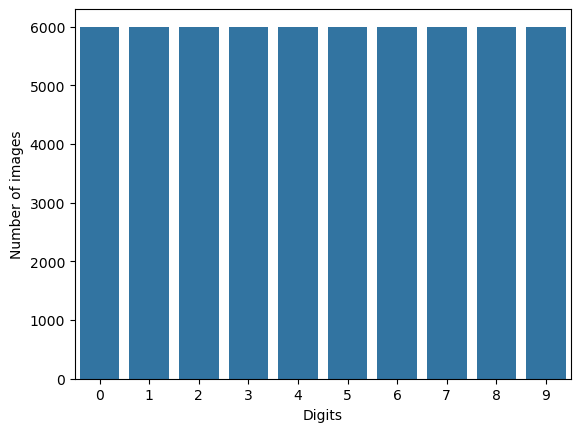

In [72]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

### <a name="5"></a> 5. Normalizacja danych

In [73]:
X_train = X_train / 255
X_test = X_test / 255

X_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
X_test = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
y_train = pd.DataFrame(y_train, columns=['label'])
y_test = pd.DataFrame(y_test, columns=['label'])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

### <a name="6"></a> 6.Zdefiniowanie CNN

In [75]:
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hiperparametry:
    learning_rate: Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw gęstych.
    num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
    activation: Funkcja aktywacji dla wszystkich warstw.
    """

    model = Sequential()

    model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    

    model.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten()) 

    
    for i in range(num_dense_layers):

        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))


    model.add(Dense(10, activation='sigmoid')) 

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

### <a name="7"></a> 7.Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście

In [76]:
path_best_model = 'cnn_model.h5'

param_grid = {
    "learning_rate": (1e-6, 1e-2),
    "num_dense_layers": (1, 5),
    "num_dense_nodes": (10, 500),
    "activation": ["relu", "sigmoid"]
}

### <a name="8"></a> 8.Zdefiniowanie funkcji wykorzystanych przez EA

In [77]:
class Individual():
    """Klasa reprezentująca pojedyńczego osobnika,
        przechowuje wszystkie jego cechy"""
    def __init__(self,
                 learning_rate = None,
                 num_dense_layers =None,
                 num_dense_nodes = None,
                 activation = None,
                 num_conv_layers = None,
                 filter_size = None,
                 kernel_size = None,
                 evaluate_ind=-1
                 ):
        self.learning_rate = learning_rate
        self.num_dense_layers = num_dense_layers
        self.num_dense_nodes = num_dense_nodes
        self.activation = activation
        self.num_conv_layers = num_conv_layers
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.evaluate_ind = evaluate_ind
        super().__init__()
    def __repr__(self):
        """Reprezentacja obiektu zawierająca wszystkie jego cechy."""
        return (
            f"Individual("
            f"learning_rate={self.learning_rate}, "
            f"num_dense_layers={self.num_dense_layers}, "
            f"num_dense_nodes={self.num_dense_nodes}, "
            f"activation={self.activation}, "
            f"num_conv_layers={self.num_conv_layers}, "
            f"filter_size={self.filter_size}, "
            f"kernel_size={self.kernel_size}, "
            f"evaluate_ind={self.evaluate_ind})"
        )

In [78]:
def mutation(individual: Individual, param_grid, p_m_con=0.1):
    """Metoda odpowiedzialna za mutacje"""

    # Pobranie wszystkich atrybutów, które nie są None
    non_none_attributes = {
        attr: value for attr, value in vars(individual).items() if value is not None
    }
    # Mutacja każdej zmiennej
    mutated_attributes = {}
    for attr, value in non_none_attributes.items():
        if attr in param_grid:  # Jeśli zmienna istnieje w param_grid
            if isinstance(param_grid[attr], tuple):  # Mutujemy tylko liczby
                mutated_attributes[attr] = mutate_variable(value, attr, param_grid, p_m_con=p_m_con)
            elif isinstance(param_grid[attr], list):  # Zmienna kategoryczna - bez mutacji
                mutated_attributes[attr] = value  # Przepisanie bez zmian
        else:
            mutated_attributes[attr] = value  # Przepisujemy wartości spoza param_grid bez zmian

    new_individual = Individual(**mutated_attributes)
    return new_individual


def mutate_variable(variable, variable_name, param_grid, length=30, p_m_con=0.2):
    """Metoda odpowiedzialna za mutację zmiennych ciągłych"""
    mutant_gene = variable
    if variable_name not in param_grid:
        raise ValueError(f"Zmienna '{variable_name}' nie istnieje w param_grid.")
    param = param_grid[variable_name]

    if isinstance(param, tuple):
        lower_bound, upper_bound = param
        # Obliczenie precyzji
        precision = (upper_bound - lower_bound) / ((2 ** length) - 1)
    else:
        raise ValueError(f"Zmienna '{variable_name}' nie jest numeryczna i nie może być mutowana.")

    #mutacja zmiennej ciągłej
    mutant_gene = encode_variable(mutant_gene,precision, lower_bound,length)
    for idx in range(len(mutant_gene)):
        if np.random.rand() < p_m_con:  # Prawdopodobieństwo mutacji
            if mutant_gene[idx] == 0:
                mutant_gene[idx] = 1
            else:
                mutant_gene[idx] = 0
    mutant_gene = decode_individual(mutant_gene, length,precision,lower_bound)
    if isinstance(variable, int):
        mutant_gene = int(round(mutant_gene))
    return mutant_gene

def encode_variable(value, precision, lower_bound, length):
    """Zakodowanie liczby do postaci bitowej"""
    shifted_value = (value - lower_bound) / precision
    int_value = int(round(shifted_value))
    binary_representation = [int(bit) for bit in bin(int_value)[2:].zfill(length)]

    return binary_representation

def decode_individual(individual, length, precision, lower_bound):
    """Dekoduje zakodowaną tablicę bitową na wartość rzeczywistą."""
    num_sum = sum(individual[-(i + 1)] * (2 ** i) for i in range(length))
    decoded_value = (num_sum * precision) + lower_bound
    return decoded_value


def crossover(parent_1: Individual, parent_2: Individual, param_grid, length=20):
    """Krzyżowanie dwóch osobników z uwzględnieniem typów cech i obliczaniem wartości `evaluate_ind`."""

    child_1_attributes = {}
    child_2_attributes = {}
    toggle = True  # Flaga do naprzemiennego przydzielania wartości cech kategorycznych

    for attr in param_grid:
        # Pomiń `evaluate_ind` w krzyżowaniu
        if attr == "evaluate_ind":
            continue

        # Pobierz wartości cechy dla obu rodziców
        value_1 = getattr(parent_1, attr)
        value_2 = getattr(parent_2, attr)

        # Jeśli cecha jest None, pomijamy ją
        if value_1 is None or value_2 is None:
            continue

        # Obsługa cech numerycznych
        if isinstance(param_grid[attr], tuple):  # Zakres wartości numerycznych
            lower_bound, upper_bound = param_grid[attr]
            precision = (upper_bound - lower_bound) / ((2 ** length) - 1)

            # Zakodowanie wartości
            binary_1 = encode_variable(value_1, precision, lower_bound, length)
            binary_2 = encode_variable(value_2, precision, lower_bound, length)

            # One-point crossover
            crossover_point = random.randint(1, length - 1 - 10)
            child_binary_1 = binary_1[:crossover_point] + binary_2[crossover_point:]
            child_binary_2 = binary_2[:crossover_point] + binary_1[crossover_point:]

            # Dekodowanie wartości
            child_value_1 = decode_individual(child_binary_1, length, precision, lower_bound)
            child_value_2 = decode_individual(child_binary_2, length, precision, lower_bound)

            # Konwersja na int dla cech takich jak `num_dense_layers`
            if attr in ['num_dense_layers', 'num_dense_nodes', 'num_conv_layers']:
                child_value_1 = int(round(child_value_1))
                child_value_2 = int(round(child_value_2))

            # Przypisanie wartości do atrybutów
            child_1_attributes[attr] = child_value_1
            child_2_attributes[attr] = child_value_2

        # Obsługa cech kategorycznych
        elif isinstance(param_grid[attr], list):  # Lista kategoryczna
            if toggle:
                child_1_attributes[attr] = value_1
                child_2_attributes[attr] = value_2
            else:
                child_1_attributes[attr] = value_2
                child_2_attributes[attr] = value_1
            toggle = not toggle  # Zmiana flagi dla naprzemienności

    # Tworzenie potomków bez `evaluate_ind`
    child_1 = Individual(**child_1_attributes)
    child_2 = Individual(**child_2_attributes)

    return child_1, child_2

def tournament_selection(population, tournament_size=2):

    # Wybierz pierwszego rodzica
    candidates_1 = random.sample(population, tournament_size)
    parent_1 = max(candidates_1, key=lambda individual: individual.evaluate_ind)

    # Wybierz drugiego rodzica, upewniając się, że jest różny od pierwszego
    while True:
        candidates_2 = random.sample(population, tournament_size)
        parent_2 = max(candidates_2, key=lambda individual: individual.evaluate_ind)
        if parent_2 != parent_1:
            break
    return parent_1, parent_2

def create_cnn(
        learning_rate,
        num_dense_layers,
        num_dense_nodes,
        activation,
):

    model = Sequential()
    model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Flatten())

    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    model.add(Dense(10, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


### <a name="9"></a> 9.  Wykonujemy proces optymalizacji bayesowskiej za pomocą algorytmu EA w wersji podstawowej i zapis oraz wyświetlenie najlepszych wyników


In [ ]:
class GeneticAlgorithm:
    def __init__(self, param_grid, iteration=9, mutation_probability=0.1,population_size=10):
        self.iteration = iteration
        self.list_num_iter = []
        self.best_solution_iter = []
        self.solution_iter = []
        self.param_grid = param_grid
        self.mutation_probability = mutation_probability
        self.path_best_model = 'cnn_model.h5'
        self.best_accuracy = 0
        self.best_hyperparameters = None
        self.solution_iter_genotype = []
        self.population_size = population_size

    def objective(self, learning_rate, num_dense_layers, num_dense_nodes, activation):
        """Funkcja celu, oceniająca model."""
        model = create_cnn(
            learning_rate=learning_rate,
            num_dense_layers=num_dense_layers,
            num_dense_nodes=num_dense_nodes,
            activation=activation
        )

        learning_rate_reduction = ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=2,
            verbose=1,
            factor=0.5,
            min_lr=0.00001
        )

        history = model.fit(
            x=X_train,
            y=y_train,
            epochs=5,
            batch_size=32,
            validation_split=0.1,
            callbacks=[learning_rate_reduction]
        )

        accuracy = history.history['val_accuracy'][-1]

            
        if accuracy > self.best_accuracy:
            model.save(self.path_best_model)
            self.best_accuracy = accuracy
            self.best_hyperparameters = {
                "learning_rate": learning_rate,
                "num_dense_layers": num_dense_layers,
                "num_dense_nodes": num_dense_nodes,
                "activation": activation
            }

            del model

        return accuracy

    def first_generate_population(self,param_grid):
        population = []
        for _ in range(self.population_size):
            random_params = {}
            for param, values in param_grid.items():
                if isinstance(values, tuple):  # Zakres wartości liczbowych
                    random_params[param] = random.uniform(*values)
                    if isinstance(values[0], int):  # Jeśli to liczba całkowita
                        random_params[param] = int(round(random_params[param]))
                elif isinstance(values, list):  # Lista kategorii
                    random_params[param] = random.choice(values)
            individual = Individual(**random_params)
            objective_args = inspect.signature(self.objective).parameters.keys()
            hyperparameters = {
                attr: value for attr, value in vars(individual).items() if attr in objective_args
            }
            individual.evaluate_ind = self.objective(**hyperparameters)
            population.append(individual)
            if individual.evaluate_ind > self.best_accuracy:
                model.save(self.path_best_model)
                self.best_accuracy = individual.evaluate_ind
                self.best_hyperparameters = {
                    "learning_rate": learning_rate,
                    "num_dense_layers": num_dense_layers,
                    "num_dense_nodes": num_dense_nodes,
                    "activation": activation
                }
            self.best_solution_iter.append(self.best_accuracy)
        return population
    def run(self):
        

        # Inicjalizacja populacji
        population = self.first_generate_population(self.param_grid)

        self.solution_iter = [individual.evaluate_ind for individual in population]
        self.solution_iter_genotype = [vars(individual) for individual in population]
        self.list_num_iter = [i for i in range(1,(self.iteration+1)*self.population_size+1)]

        iteration = 1
        for i in range(self.iteration):

            new_population = []
            # Generowanie nowej populacji
            for j in range(self.population_size//2):

                parent_1, parent_2 = tournament_selection(population)
                child_1, child_2 = crossover(parent_1, parent_2, self.param_grid)
                while vars(child_1) == vars(child_2):
                    child_1, child_2 = crossover(parent_1, parent_2, self.param_grid)

                if random.random() <= self.mutation_probability:
                    child_1 = mutation(child_1, self.param_grid)

                # Obliczenie oceny dla child_1
                objective_args = inspect.signature(self.objective).parameters.keys()
                hyperparameters_1 = {
                    attr: value for attr, value in vars(child_1).items()
                    if attr in objective_args
                }
                child_1.evaluate_ind = self.objective(**hyperparameters_1)

                if random.random() <= self.mutation_probability:
                    child_2 = mutation(child_2, param_grid)

                # Obliczenie oceny dla child_2
                hyperparameters_2 = {
                    attr: value for attr, value in vars(child_2).items()
                    if attr in objective_args
                }
                child_2.evaluate_ind = self.objective(**hyperparameters_2)

                new_population.append(child_1)
                self.best_solution_iter.append(self.best_accuracy)
                new_population.append(child_2)
                self.best_solution_iter.append(self.best_accuracy)
                self.solution_iter.append(child_1.evaluate_ind)
                self.solution_iter_genotype.append(vars(child_1))
                self.solution_iter.append(child_2.evaluate_ind)
                self.solution_iter_genotype.append(vars(child_2))
            population = new_population

            iteration += 1
        print(self.solution_iter_genotype)
        print("Najlepsze hiperparametry:", self.best_hyperparameters)
        print("Najlepsza dokładność:", self.best_accuracy)
        self.save_to_files()

    def save_to_files(self):
        """Zapisuje dane iteracji do plików CSV."""
        solution_data = {
            "Iteration": self.list_num_iter,
            "Solutions": self.solution_iter
        }
        df_solutions = pd.DataFrame(solution_data)
        df_solutions.to_csv("solutions.csv", index=False)
        print("Zapisano plik: solutions.csv")

        
        best_solution_data = {
            "Iteration": self.list_num_iter,
            "Best Accuracy": self.best_solution_iter
        }
        print(self.solution_iter_genotype)
        df_best_solutions = pd.DataFrame(best_solution_data)
        df_best_solutions.to_csv("best_solutions.csv", index=False)
        print("Zapisano plik: best_solutions.csv")
        
        
        
        genotype_data = []
        

        for i, genotype_dict in enumerate(
                self.solution_iter_genotype): 
            if isinstance(genotype_dict, dict):  
                genotype_data.append({"Iteration": i + 1, **genotype_dict})
            else:
                print(f"Nieprawidłowy genotyp: {genotype_dict}")

        print("Wynik genotype_data:", genotype_data)

        df_genotypes = pd.DataFrame(genotype_data)
        df_genotypes.to_csv("genotypes.csv", index=False)
        print("Zapisano plik: genotypes.csv")



        


if __name__ == "__main__":

    genetic_algorithm = GeneticAlgorithm(
        iteration = 9,
        param_grid = param_grid,
        mutation_probability=0.1,
        population_size=10
    )
    start_time = time.time()
    genetic_algorithm.run()
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"Czas wykonania funkcji run: {execution_time:.2f} sekund")

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.0974 - loss: 0.3363 - val_accuracy: 0.1032 - val_loss: 0.3297 - learning_rate: 0.0086
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0999 - loss: 0.3312 - val_accuracy: 0.1027 - val_loss: 0.3280 - learning_rate: 0.0086
Epoch 3/5
1683/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1010 - loss: 0.3306
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00429876521229744.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1010 - loss: 0.3306 - val_accuracy: 0.1027 - val_loss: 0.3288 - learning_rate: 0.0086
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0991 - loss: 0.3282 - val_accuracy: 0.0925 - val_loss: 0.3292 - learning_rate: 0.0043
Epoch 5/5
1682/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0984 - loss: 0.3285
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00214938260614872.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0984 - loss: 0

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.0989 - loss: 0.3369 - val_accuracy: 0.0985 - val_loss: 0.3307 - learning_rate: 0.0060
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.1001 - loss: 0.3311 - val_accuracy: 0.0925 - val_loss: 0.3355 - learning_rate: 0.0060
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.0974 - loss: 0.3307 - val_accuracy: 0.1050 - val_loss: 0.3300 - learning_rate: 0.0060
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.0999 - loss: 0.3308 - val_accuracy: 0.0925 - val_loss: 0.3327 - learning_rate: 0.0060
Epoch 5/5
1685/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1017 - loss: 0.3307
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0030040412675589323.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.1017 - loss: 0.3307 - val_accuracy: 0.1027 - val_loss: 0.3279 - learning_rate: 0.0060


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6857 - loss: 0.1440 - val_accuracy: 0.8782 - val_loss: 0.0614 - learning_rate: 0.0036
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8848 - loss: 0.0585 - val_accuracy: 0.8957 - val_loss: 0.0525 - learning_rate: 0.0036
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9008 - loss: 0.0496 - val_accuracy: 0.8983 - val_loss: 0.0510 - learning_rate: 0.0036
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9098 - loss: 0.0447 - val_accuracy: 0.9033 - val_loss: 0.0514 - learning_rate: 0.0036
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9162 - loss: 0.0423 - val_accuracy: 0.9022 - val_loss: 0.0545 - learning_rate: 0.0036


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1012 - loss: 0.3319 - val_accuracy: 0.1055 - val_loss: 0.3272 - learning_rate: 0.0087
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1002 - loss: 0.3263 - val_accuracy: 0.0985 - val_loss: 0.3254 - learning_rate: 0.0087
Epoch 3/5
1684/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0974 - loss: 0.3259
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0043631307780742645.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0974 - loss: 0.3259 - val_accuracy: 0.0973 - val_loss: 0.3255 - learning_rate: 0.0087
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0999 - loss: 0.3254 - val_accuracy: 0.0973 - val_loss: 0.3257 - learning_rate: 0.0044
Epoch 5/5
1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1004 - loss: 0.3254
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0021815653890371323.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1004 - los

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.0992 - loss: 0.3314 - val_accuracy: 0.0925 - val_loss: 0.3268 - learning_rate: 0.0015
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.0983 - loss: 0.3271 - val_accuracy: 0.0985 - val_loss: 0.3273 - learning_rate: 0.0015
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.0964 - loss: 0.3273 - val_accuracy: 0.0973 - val_loss: 0.3259 - learning_rate: 0.0015
Epoch 4/5
1687/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1003 - loss: 0.3269
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0007598568336106837.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.1003 - loss: 0.3269 - val_accuracy: 0.0942 - val_loss: 0.3264 - learning_rate: 0.0015
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.1014 - loss: 0.3259 - val_accuracy: 0.0985 - val_loss: 0.3258 - learning_rate: 7.5986e-04
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7917 

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7333 - loss: 0.1281 - val_accuracy: 0.8882 - val_loss: 0.0565 - learning_rate: 5.2651e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8915 - loss: 0.0537 - val_accuracy: 0.9033 - val_loss: 0.0479 - learning_rate: 5.2651e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9139 - loss: 0.0431 - val_accuracy: 0.9078 - val_loss: 0.0464 - learning_rate: 5.2651e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9292 - loss: 0.0359 - val_accuracy: 0.9122 - val_loss: 0.0440 - learning_rate: 5.2651e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9392 - loss: 0.0303 - val_accuracy: 0.9165 - val_loss: 0.0432 - learning_rate: 5.2651e-04


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6319 - loss: 0.1721 - val_accuracy: 0.8435 - val_loss: 0.0762 - learning_rate: 2.9485e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8550 - loss: 0.0705 - val_accuracy: 0.8773 - val_loss: 0.0631 - learning_rate: 2.9485e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8846 - loss: 0.0577 - val_accuracy: 0.8888 - val_loss: 0.0560 - learning_rate: 2.9485e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8978 - loss: 0.0510 - val_accuracy: 0.8938 - val_loss: 0.0524 - learning_rate: 2.9485e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9067 - loss: 0.0462 - val_accuracy: 0.9000 - val_loss: 0.0533 - learning_rate: 2.9485e-04
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0991 - loss: 0.3317 - val_accuracy: 0.1027 - val_loss: 0.3300 - learning_rate: 0.0046
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - 

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.1001 - loss: 0.3386 - val_accuracy: 0.1050 - val_loss: 0.3260 - learning_rate: 3.0913e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.1013 - loss: 0.3261 - val_accuracy: 0.1032 - val_loss: 0.3252 - learning_rate: 3.0913e-04
Epoch 3/5
1684/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1021 - loss: 0.3259
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00015456513210665435.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.1021 - loss: 0.3259 - val_accuracy: 0.0985 - val_loss: 0.3259 - learning_rate: 3.0913e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.0997 - loss: 0.3254 - val_accuracy: 0.0942 - val_loss: 0.3253 - learning_rate: 1.5457e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2030 - loss: 0.2944 - val_accuracy: 0.7562 - val_loss: 0.1140 - learning_rate: 1.5457e-04
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - 

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7196 - loss: 0.1323 - val_accuracy: 0.8848 - val_loss: 0.0551 - learning_rate: 6.0207e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8929 - loss: 0.0540 - val_accuracy: 0.9012 - val_loss: 0.0504 - learning_rate: 6.0207e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9095 - loss: 0.0442 - val_accuracy: 0.9073 - val_loss: 0.0457 - learning_rate: 6.0207e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9242 - loss: 0.0383 - val_accuracy: 0.9130 - val_loss: 0.0440 - learning_rate: 6.0207e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9335 - loss: 0.0328 - val_accuracy: 0.9103 - val_loss: 0.0489 - learning_rate: 6.0207e-04
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7454 - loss: 0.1184 - val_accuracy: 0.8898 - val_loss: 0.0569 - learning_rate: 0.0019
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - 

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7183 - loss: 0.1317 - val_accuracy: 0.8717 - val_loss: 0.0634 - learning_rate: 6.0207e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8898 - loss: 0.0546 - val_accuracy: 0.8968 - val_loss: 0.0511 - learning_rate: 6.0207e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9075 - loss: 0.0452 - val_accuracy: 0.9097 - val_loss: 0.0443 - learning_rate: 6.0207e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9224 - loss: 0.0379 - val_accuracy: 0.9058 - val_loss: 0.0488 - learning_rate: 6.0207e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9333 - loss: 0.0329 - val_accuracy: 0.9157 - val_loss: 0.0414 - learning_rate: 6.0207e-04
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7716 - loss: 0.1073 - val_accuracy: 0.8965 - val_loss: 0.0539 - learning_rate: 0.0019
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - 

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7209 - loss: 0.1298 - val_accuracy: 0.8890 - val_loss: 0.0553 - learning_rate: 6.0207e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8933 - loss: 0.0527 - val_accuracy: 0.8978 - val_loss: 0.0500 - learning_rate: 6.0207e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9134 - loss: 0.0423 - val_accuracy: 0.9085 - val_loss: 0.0456 - learning_rate: 6.0207e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9241 - loss: 0.0371 - val_accuracy: 0.9107 - val_loss: 0.0445 - learning_rate: 6.0207e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9359 - loss: 0.0311 - val_accuracy: 0.9145 - val_loss: 0.0425 - learning_rate: 6.0207e-04
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7317 - loss: 0.1273 - val_accuracy: 0.8698 - val_loss: 0.0637 - learning_rate: 6.0207e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/ste

PermissionError: [Errno 13] Permission denied: 'genotypes.csv'

# **Uwaga:** kod zakończył poprawnie obliczanie algorytmu, widoczne błędy są związane z zapisem do pliku, które zostały poprawione.

## **Poprawny zapis do pliku dokonano poniżej.**

In [83]:
genotype_data = []
for i, genotype_dict in enumerate(genetic_algorithm.solution_iter_genotype):  # Zakładamy, że self.solution_iter_genotype to lista słowników
    if isinstance(genotype_dict, dict):  # Upewnij się, że to słownik
        genotype_data.append({"Iteration": i + 1, **genotype_dict})
    else:
        print(f"Nieprawidłowy genotyp: {genotype_dict}")

print("Wynik genotype_data:", genotype_data)

df_genotypes = pd.DataFrame(genotype_data)
df_genotypes.to_csv("genotypes.csv", index=False)
print("Zapisano plik: genotypes.csv")

Wynik genotype_data: [{'Iteration': 1, 'learning_rate': 0.008597530315070911, 'num_dense_layers': 2, 'num_dense_nodes': 259, 'activation': 'sigmoid', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.0925000011920929}, {'Iteration': 2, 'learning_rate': 0.006008082440555183, 'num_dense_layers': 2, 'num_dense_nodes': 361, 'activation': 'sigmoid', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.10266666859388351}, {'Iteration': 3, 'learning_rate': 0.0035744894065085253, 'num_dense_layers': 3, 'num_dense_nodes': 336, 'activation': 'relu', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.9021666646003723}, {'Iteration': 4, 'learning_rate': 0.008726262021584608, 'num_dense_layers': 4, 'num_dense_nodes': 33, 'activation': 'sigmoid', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.10316666960716248}, {'Iteration': 5, 'learning_rate': 0.001857190958795

In [85]:
# Przygotowanie danych do drugiego pliku
best_solution_data = {
"Iteration": genetic_algorithm.list_num_iter,
"Best Accuracy": genetic_algorithm.best_solution_iter
}
print(genetic_algorithm.solution_iter_genotype)
df_best_solutions = pd.DataFrame(best_solution_data)
df_best_solutions.to_csv("best_solutions.csv", index=False)
print("Zapisano plik: best_solutions.csv")

[{'learning_rate': 0.008597530315070911, 'num_dense_layers': 2, 'num_dense_nodes': 259, 'activation': 'sigmoid', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.0925000011920929}, {'learning_rate': 0.006008082440555183, 'num_dense_layers': 2, 'num_dense_nodes': 361, 'activation': 'sigmoid', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.10266666859388351}, {'learning_rate': 0.0035744894065085253, 'num_dense_layers': 3, 'num_dense_nodes': 336, 'activation': 'relu', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.9021666646003723}, {'learning_rate': 0.008726262021584608, 'num_dense_layers': 4, 'num_dense_nodes': 33, 'activation': 'sigmoid', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.10316666960716248}, {'learning_rate': 0.001857190958795133, 'num_dense_layers': 3, 'num_dense_nodes': 319, 'activation': 'relu', 'num_conv_layers': None, 'f

In [87]:
print(genetic_algorithm.best_hyperparameters)

{'learning_rate': 0.00185196525570417, 'num_dense_layers': 3, 'num_dense_nodes': 274, 'activation': 'relu'}


### <a name="10"></a> 10. Ocena modelu na zbiorze testowym

In [86]:
model = load_model('cnn_model.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9159 - loss: 0.0484
Test Loss: 0.046210721135139465
Test Accuracy: 0.9172999858856201
